
 실험 A.1 - CrossEntropyLoss
[Epoch 1/20] 진행률: 100.0%
Epoch 1 | Loss: 0.5235 | Accuracy: 84.52%
[Epoch 2/20] 진행률: 100.0%
Epoch 2 | Loss: 0.3701 | Accuracy: 85.73%
[Epoch 3/20] 진행률: 100.0%
Epoch 3 | Loss: 0.3326 | Accuracy: 86.67%
[Epoch 4/20] 진행률: 100.0%
Epoch 4 | Loss: 0.3073 | Accuracy: 86.40%
[Epoch 5/20] 진행률: 100.0%
Epoch 5 | Loss: 0.2884 | Accuracy: 86.18%
[Epoch 6/20] 진행률: 100.0%
Epoch 6 | Loss: 0.2714 | Accuracy: 87.92%
[Epoch 7/20] 진행률: 100.0%
Epoch 7 | Loss: 0.2593 | Accuracy: 88.53%
[Epoch 8/20] 진행률: 100.0%
Epoch 8 | Loss: 0.2470 | Accuracy: 88.98%
[Epoch 9/20] 진행률: 100.0%
Epoch 9 | Loss: 0.2410 | Accuracy: 88.91%
[Epoch 10/20] 진행률: 100.0%
Epoch 10 | Loss: 0.2254 | Accuracy: 88.59%
[Epoch 11/20] 진행률: 100.0%
Epoch 11 | Loss: 0.2182 | Accuracy: 88.72%
[Epoch 12/20] 진행률: 100.0%
Epoch 12 | Loss: 0.2110 | Accuracy: 88.59%
[Epoch 13/20] 진행률: 100.0%
Epoch 13 | Loss: 0.2025 | Accuracy: 88.97%
[Epoch 14/20] 진행률: 100.0%
Epoch 14 | Loss: 0.1957 | Accuracy: 88.70%
[Epoch 15/20] 진행률: 100.0

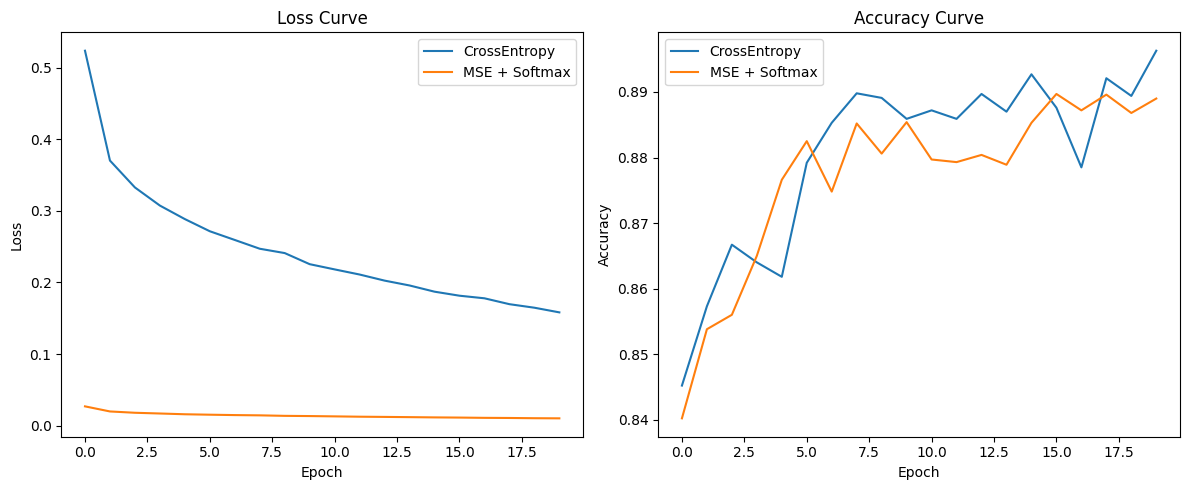

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys

# 하이퍼파라미터 설정
batch_size = 64            # 한 번에 처리할 이미지 개수
num_epochs = 20            # 전체 데이터셋을 몇 번 반복해서 학습할지
learning_rate = 0.001      # 가중치 업데이트 시 얼마나 크게 이동할지
# GPU가 있으면 GPU 사용, 없으면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로딩 및 전처리
# FashionMNIST: 28x28 흑백 이미지, 10가지 옷 카테고리
transform = transforms.ToTensor()  # 이미지를 0~1 사이 값의 Tensor로 변환
trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

# DataLoader: 배치 단위로 묶고 셔플 여부 설정
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False)

# 모델 정의: 간단한 Fully Connected 신경망
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # 모델 아키텍처를 한 줄로 정의: Flatten -> Linear -> ReLU -> ...
        self.net = nn.Sequential(
            nn.Flatten(),            # 28x28 이미지를 784 길이 벡터로 펼침
            nn.Linear(28*28, 256),  # 입력: 784, 출력: 256
            nn.ReLU(),              # 비선형 활성화 함수
            nn.Linear(256, 128),    # 은닉층: 256 -> 128
            nn.ReLU(),
            nn.Linear(128, 10)      # 출력층: 128 -> 10 클래스
        )

    def forward(self, x):
        # 순전파 함수: 입력 x를 받아 순차적으로 처리
        return self.net(x)

# 정확도 평가 함수
def evaluate(model, dataloader):
    """
    모델을 평가 모드로 전환한 뒤, 주어진 데이터로 정확도를 계산합니다.
    - model.eval(): 드롭아웃, 배치 정규화 등을 평가 모드로 설정
    - torch.no_grad(): 그래디언트 계산 비활성화로 메모리 절약 및 속도 개선
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            # 장치에 데이터 올리기
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # 예측 로그잇
            # 가장 높은 확률의 인덱스를 예측 결과로 선택
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 학습 함수: 손실 함수와 softmax 옵션을 인자로 받아 실험할 수 있도록
def train_model(loss_fn, use_softmax=False):
    """
    loss_fn: 사용할 손실 함수 객체 (CrossEntropyLoss 또는 MSELoss)
    use_softmax: MSELoss 사용 시 softmax를 적용하려면 True
    """
    # 새로운 모델 인스턴스 생성 및 장치 할당
    model = SimpleNet().to(device)
    # Adam 옵티마이저 초기화 (다른 실험에서 교체 가능)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_list = []  # 에폭별 평균 손실 저장
    test_acc_list = []    # 에폭별 테스트 정확도 저장

    # 에폭 반복
    for epoch in range(num_epochs):
        model.train()      # 학습 모드로 전환
        running_loss = 0.0
        total_steps = len(trainloader)

        # 배치 단위 학습
        for i, (images, labels) in enumerate(trainloader, start=1):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()   # 이전 배치의 그래디언트 초기화
            outputs = model(images) # 순전파

            if use_softmax:
                # MSELoss는 확률 분포와 비교해야 하므로 softmax 적용
                outputs = torch.softmax(outputs, dim=1)
                # 정수 레이블 → one-hot 벡터로 변환
                labels_one_hot = nn.functional.one_hot(labels, num_classes=10).float()
                loss = loss_fn(outputs, labels_one_hot)
            else:
                # CrossEntropyLoss는 내부 softmax 포함
                loss = loss_fn(outputs, labels)

            loss.backward()    # 역전파로 그래디언트 계산
            optimizer.step()   # 옵티마이저 스텝
            running_loss += loss.item()

            # 진행률 출력(같은 줄에 덮어쓰기)
            sys.stdout.write(f"\r[Epoch {epoch+1}/{num_epochs}] 진행률: {i/total_steps*100:.1f}%")
            sys.stdout.flush()

        print()  # 에폭이 끝나면 줄바꿈
        avg_loss = running_loss / total_steps
        acc = evaluate(model, testloader)
        train_loss_list.append(avg_loss)
        test_acc_list.append(acc)
        # 에폭별 손실과 정확도 출력
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {acc*100:.2f}%")

    return train_loss_list, test_acc_list

# 실험 A.1: CrossEntropyLoss
print("\n 실험 A.1 - CrossEntropyLoss")
loss_fn_ce = nn.CrossEntropyLoss()  # 분류 문제에 주로 쓰이는 손실 함수
ce_loss, ce_acc = train_model(loss_fn_ce, use_softmax=False)

# 실험 A.2: MSELoss (Softmax 포함)
print("\n 실험 A.2 - MSELoss (with Softmax)")
loss_fn_mse = nn.MSELoss()  # 회귀용 손실 함수이지만 여기선 비교 실험용
mse_loss, mse_acc = train_model(loss_fn_mse, use_softmax=True)

# 결과 시각화: Loss와 Accuracy 곡선 비교
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(ce_loss, label='CrossEntropy')       # CE는 빠르게 안정적으로 수렴함
plt.plot(mse_loss, label='MSE + Softmax')    # MSE는 느리고 진동이 심함
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(ce_acc, label='CrossEntropy')
plt.plot(mse_acc, label='MSE + Softmax')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()  # 그래프를 화면에 표시

# 출력 결과 주석
"""
모델 구조는 동일하게 구성하고 손실 함수만 각각 적용해 학습을 진행했다.
CrossEntropyLoss는 분류 문제에서 일반적으로 많이 쓰이며 내부적으로 Softmax와 log를 함께 적용해 gradient 흐름이 잘 유지된다.
반면 MSELoss는 회귀 문제에서 주로 쓰이지만 이번 실험에서는 출력층에 Softmax를 붙이고 정답 라벨을 one-hot 인코딩하여 분류 문제에 맞게 조정해 사용했다.
코드에는 손실 함수별 특징, Softmax 사용 이유, gradient 관련 이슈 등을 주석으로 정리해두었다.

실험 A.1 - CrossEntropyLoss
[Epoch 1/20] 진행률: 100.0%
Epoch 1 | Loss: 0.5235 | Accuracy: 84.52%
[Epoch 2/20] 진행률: 100.0%
Epoch 2 | Loss: 0.3701 | Accuracy: 85.73%
[Epoch 3/20] 진행률: 100.0%
Epoch 3 | Loss: 0.3326 | Accuracy: 86.67%
[Epoch 4/20] 진행률: 100.0%
Epoch 4 | Loss: 0.3073 | Accuracy: 86.40%
[Epoch 5/20] 진행률: 100.0%
Epoch 5 | Loss: 0.2884 | Accuracy: 86.18%
[Epoch 6/20] 진행률: 100.0%
Epoch 6 | Loss: 0.2714 | Accuracy: 87.92%
[Epoch 7/20] 진행률: 100.0%
Epoch 7 | Loss: 0.2593 | Accuracy: 88.53%
[Epoch 8/20] 진행률: 100.0%
Epoch 8 | Loss: 0.2470 | Accuracy: 88.98%
[Epoch 9/20] 진행률: 100.0%
Epoch 9 | Loss: 0.2410 | Accuracy: 88.91%
[Epoch 10/20] 진행률: 100.0%
Epoch 10 | Loss: 0.2254 | Accuracy: 88.59%
[Epoch 11/20] 진행률: 100.0%
Epoch 11 | Loss: 0.2182 | Accuracy: 88.72%
[Epoch 12/20] 진행률: 100.0%
Epoch 12 | Loss: 0.2110 | Accuracy: 88.59%
[Epoch 13/20] 진행률: 100.0%
Epoch 13 | Loss: 0.2025 | Accuracy: 88.97%
[Epoch 14/20] 진행률: 100.0%
Epoch 14 | Loss: 0.1957 | Accuracy: 88.70%
[Epoch 15/20] 진행률: 100.0%
Epoch 15 | Loss: 0.1871 | Accuracy: 89.27%
[Epoch 16/20] 진행률: 100.0%
Epoch 16 | Loss: 0.1814 | Accuracy: 88.76%
[Epoch 17/20] 진행률: 100.0%
Epoch 17 | Loss: 0.1778 | Accuracy: 87.85%
[Epoch 18/20] 진행률: 100.0%
Epoch 18 | Loss: 0.1696 | Accuracy: 89.21%
[Epoch 19/20] 진행률: 100.0%
Epoch 19 | Loss: 0.1647 | Accuracy: 88.94%
[Epoch 20/20] 진행률: 100.0%
Epoch 20 | Loss: 0.1582 | Accuracy: 89.63%

실험 A.2 - MSELoss (with Softmax)
[Epoch 1/20] 진행률: 100.0%
Epoch 1 | Loss: 0.0270 | Accuracy: 84.02%
[Epoch 2/20] 진행률: 100.0%
Epoch 2 | Loss: 0.0199 | Accuracy: 85.38%
[Epoch 3/20] 진행률: 100.0%
Epoch 3 | Loss: 0.0180 | Accuracy: 85.60%
[Epoch 4/20] 진행률: 100.0%
Epoch 4 | Loss: 0.0170 | Accuracy: 86.50%
[Epoch 5/20] 진행률: 100.0%
Epoch 5 | Loss: 0.0159 | Accuracy: 87.66%
[Epoch 6/20] 진행률: 100.0%
Epoch 6 | Loss: 0.0153 | Accuracy: 88.25%
[Epoch 7/20] 진행률: 100.0%
Epoch 7 | Loss: 0.0148 | Accuracy: 87.48%
[Epoch 8/20] 진행률: 100.0%
Epoch 8 | Loss: 0.0144 | Accuracy: 88.52%
[Epoch 9/20] 진행률: 100.0%
Epoch 9 | Loss: 0.0137 | Accuracy: 88.06%
[Epoch 10/20] 진행률: 100.0%
Epoch 10 | Loss: 0.0134 | Accuracy: 88.54%
[Epoch 11/20] 진행률: 100.0%
Epoch 11 | Loss: 0.0130 | Accuracy: 87.97%
[Epoch 12/20] 진행률: 100.0%
Epoch 12 | Loss: 0.0125 | Accuracy: 87.93%
[Epoch 13/20] 진행률: 100.0%
Epoch 13 | Loss: 0.0122 | Accuracy: 88.04%
[Epoch 14/20] 진행률: 100.0%
Epoch 14 | Loss: 0.0119 | Accuracy: 87.89%
[Epoch 15/20] 진행률: 100.0%
Epoch 15 | Loss: 0.0116 | Accuracy: 88.53%
[Epoch 16/20] 진행률: 100.0%
Epoch 16 | Loss: 0.0113 | Accuracy: 88.97%
[Epoch 17/20] 진행률: 100.0%
Epoch 17 | Loss: 0.0109 | Accuracy: 88.72%
[Epoch 18/20] 진행률: 100.0%
Epoch 18 | Loss: 0.0107 | Accuracy: 88.96%
[Epoch 19/20] 진행률: 100.0%
Epoch 19 | Loss: 0.0104 | Accuracy: 88.68%
[Epoch 20/20] 진행률: 100.0%
Epoch 20 | Loss: 0.0102 | Accuracy: 88.90%
"""